In [1]:
import datetime
#required 3rd party libs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import tqdm
import pickle as pkl
import sklearn

#required local libs
from make_time_windows import make_sample_spaces
import knn_correlations
import frequency_domain


# Binary classification of trust where majority dictates label

In [2]:
def get_timewindow_trustscore(time_window: pd.DataFrame) -> int:
    #get the trust score of the time window
    time_window_trustscore = 1 if time_window["trustscore"].mean() > 0.5 else 0
    return time_window_trustscore

# Read in provided data

In [3]:
#read in labelled data
df = pd.read_csv("data.csv")

#convert to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])

#decalre the metric to use
metric = "temperature"


Define dfs with original and RWI (random walk infit) data as they will be treated slightly diffently.
The names of columns are hard coded in the functions used

In [4]:
labelled_original_data = pd.DataFrame()
labelled_original_data[['datetime', 'moteid', metric, 'trustscore']] = df[['datetime', 'moteid', 'realworld', 'realworld_trustscore']]

labelled_randwalk_data = pd.DataFrame()
labelled_randwalk_data[['datetime', 'moteid', metric, 'trustscore']] = df[['datetime', 'moteid', 'randwalk', 'randwalk_trustscore']]


Used time windows of 2 hours shifted by 1 hour. Samplespaces is a list of dataframes that adhere to this.

In [5]:
#make time windows 
hour = datetime.timedelta(hours=1)
samplespaces_original = make_sample_spaces(labelled_original_data, hour*2, hour*1)
samplespaces_randwalk = make_sample_spaces(labelled_randwalk_data, hour*2, hour*1)

100%|██████████| 899/899 [00:13<00:00, 64.46it/s]


Near neighbours have already been calculated and are loaded from the neighbour map provided.

We use this to get correlation features that summarise the time windows we created

In [6]:
def save(data, path):
    with open(path, "wb") as file:
        pkl.dump(data, file)


def load(path):
    with open(path, "rb") as file:
        var = pkl.load(file)
    return var

In [7]:
freq_arr_original = np.array(frequency_domain.main(samplespaces_original, metric))
freq_arr_randwalk = np.array(frequency_domain.main(samplespaces_randwalk, metric))

100%|██████████| 775/775 [00:14<00:00, 54.59it/s]


In [8]:
# save as pkl
save(freq_arr_original, "freq_arr_original.pkl")
save(freq_arr_randwalk, "freq_arr_randwalk.pkl")

In [9]:
#load pkl
freq_arr_original =load("freq_arr_original.pkl")
print(freq_arr_original.shape)
freq_arr_randwalk = load("freq_arr_randwalk.pkl")
print(freq_arr_randwalk.shape)


(775, 54, 10)
(775, 54, 10)


In [ ]:
#calculate 7 nearest correlations (hard coded)
neighbour_map = pd.read_csv("neighbour_map.csv")
correlations_original = knn_correlations.main(samplespaces_original, neighbour_map, metric)
correlations_randwalk = knn_correlations.main(samplespaces_randwalk, neighbour_map, metric)
corr_arr_original = np.array(correlations_original)
corr_arr_randwalk = np.array(correlations_randwalk)


In [ ]:
# save as pkl
save(corr_arr_original, "corr_arr_original.pkl")
save(corr_arr_randwalk, "corr_arr_randwalk.pkl")

In [11]:
#load pkl
corr_arr_original =load("corr_arr_original.pkl")
print(corr_arr_original.shape)
corr_arr_randwalk = load("corr_arr_randwalk.pkl")
print(corr_arr_randwalk.shape)

(775, 54, 7)
(775, 54, 7)


We do the same with freqency features

We decide to determine trust levels for mote 1 so we combine like features for mote 1 (note that untrustworthy and trustworthy windows are unbalanced)

In [12]:
# select features for mote 1
mote_num = 1
X_freq = np.concatenate((freq_arr_original, freq_arr_randwalk), axis=0)[:, mote_num-1, :] 
X_corr = np.concatenate((corr_arr_original, corr_arr_randwalk), axis=0)[:, mote_num-1, :]

We normalise using standard scaler and then combine normalised features

In [13]:
# use standard scaler to normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_freq_norm = scaler.fit_transform(X_freq)
X_corr_norm = scaler.fit_transform(X_corr)

# concatenate the two feature sets
X_norm0 = np.concatenate((X_freq_norm, X_corr_norm), axis=1)
X_norm0.shape

(1550, 17)

Visulaise features using TSNE dimension reduction algorithm

In [14]:
from sklearn.manifold import TSNE
# get TSNE 2D representation
X = X_norm0
TSNEarr = np.array(TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(X), dtype=np.double)


C:\Users\TAD014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [15]:
# get trust scores where 1 is trusted and 0 is untrusted
# y contains some untrusted data from the original dataset and is given a trust score of 0.5
# both y and y2 assume that all data from the randwalk dataset is untrusworthy
original_trust = np.array([get_timewindow_trustscore(time_window) for time_window in samplespaces_original], dtype=np.double)
original_trust[original_trust == 0] = 0.5
randwalk_trust = np.array([get_timewindow_trustscore(time_window) for time_window in samplespaces_randwalk], dtype=np.double)
y = np.concatenate((original_trust, randwalk_trust), axis=0)

Using verdis cmap, yellow is trustworthy, blue is realworld untrustworthy and purple is synthesised untrustworthy

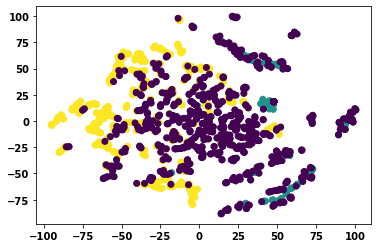

In [16]:
# plot TSNE for visualiastion purposes only
plt.scatter(TSNEarr[:,0], TSNEarr[:,1], c=y, cmap='viridis')

In [17]:
original_trust1 = np.array([get_timewindow_trustscore(time_window) for time_window in samplespaces_original])
randwalk_trust1 = np.array([get_timewindow_trustscore(time_window) for time_window in samplespaces_randwalk])
y1= np.concatenate((original_trust1, randwalk_trust1), axis=0)

# Balance the proportion of labels in data set

In [18]:
#proportion of data that is trustworthy
print("before balancing" ,len(np.where(y1 == 1)[0])/len(y1))
n = np.where(y1 ==0)[0].shape[0] - len(np.where(y1 == 1)[0])
untrustworthy_idx = np.where(y1 ==0)[0]
sampled_idx = np.random.choice(untrustworthy_idx, size=n, replace=False)


before balancing 0.3529032258064516


In [19]:
y2 = np.delete(y1, sampled_idx)
X_norm = np.delete(X_norm0, sampled_idx, axis=0)
print("after balancing", len(np.where(y2 == 1)[0])/len(y2))

after balancing 0.5


In [20]:
# now implement ML algorithms to classify the data using X_norm and y2
# the following code is just an example of how to do this
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_norm, y2, test_size=0.2, random_state=0)


In [21]:
#implement MLP
from sklearn.neural_network import MLPClassifier
clf_MLP = MLPClassifier(  solver='adam',
                        alpha=1e-3, 
                        activation = 'relu',
                        tol = 1e-4,
                        beta_1=0.8,
                        beta_2=0.9,
                        epsilon=1e-4,
                        learning_rate_init=0.001,
                        hidden_layer_sizes=(30),
                        random_state=42, 
                        n_iter_no_change = 20,
                        max_iter=20000)
clf_MLP.fit(X_train, y_train)
y_pred = clf_MLP.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.9315068493150684


In [22]:
#implement SVM
from sklearn import svm
clf_SVM = svm.SVC(kernel='rbf', C=290, gamma=1)
clf_SVM.fit(X_train, y_train)
y_pred = clf_SVM.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9223744292237442


In [23]:
#implement label propagation with random 10 percent of the data as labelled
X_train_10 = X_train[:int(len(X_train)*0.1)]
y_train_10 = y_train[:int(len(y_train)*0.1)]
from sklearn.semi_supervised import LabelPropagation
clf_LP = LabelPropagation(kernel='rbf', gamma=1, n_jobs=-1)
clf_LP.fit(X_train_10, y_train_10)
y_pred = clf_LP.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8721461187214612


In [24]:
#show all accuracy scores
print("MLP: ", accuracy_score(y_test, clf_MLP.predict(X_test)))
print("SVM: ", accuracy_score(y_test, clf_SVM.predict(X_test)))
print("Label Propagation: ", accuracy_score(y_test, clf_LP.predict(X_test)))

MLP:  0.9315068493150684
SVM:  0.9223744292237442
Label Propagation:  0.8721461187214612
